# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

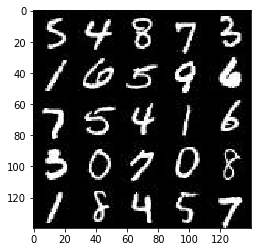

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

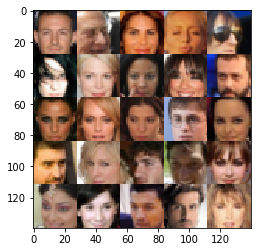

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # The first element None at the tuple are just the flex dimention 
    real_imgs_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 'real_input')
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), 'z_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_imgs_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
# Constants reusable for adversarials
stride = 5
padding = 2
img_filter_size = 64
h2_img_filter_size = img_filter_size*2
h3_img_filter_size = img_filter_size*4

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # No alpha given so making a test        
        alpha = 0.2      
        
        # 1st Hidden layer
        h1 = tf.layers.conv2d(images, img_filter_size, stride, padding, 'same')
        h1 = tf.maximum(alpha * h1, h1) # Leaky ReLU
        
        # 2nd Hidden layer
        h2 = tf.layers.conv2d(h1, h2_img_filter_size, stride, padding, 'same')
        h2 = tf.layers.batch_normalization(h2, training=True) # Batch normalizing
        h2 = tf.maximum(alpha * h2, h2) # Leaky ReLU
        
        # 3rd Hidden layer
        h3 = tf.layers.conv2d(h2, h3_img_filter_size, stride, padding, 'same')
        h3 = tf.layers.batch_normalization(h3, training=True) # Batch normalizing
        h3 = tf.maximum(alpha * h3, h3) # Leaky ReLU
        
        flat = tf.reshape(h3, (-1, 4*4*h3_img_filter_size))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Using the reverse process of the discriminator
        alpha = 0.2
    
        h1 = tf.layers.dense(z, 2*2*h3_img_filter_size)
        h1 = tf.reshape(h1, (-1, 2, 2, h3_img_filter_size))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
    
        h2 = tf.layers.conv2d_transpose(h1, h2_img_filter_size, 5, 2, 'valid')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
    
        h3 = tf.layers.conv2d_transpose(h2, img_filter_size, 5, 2, 'same')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
    
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Initializing Variables with predictions
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Empty TF TrainableVariables
    t_vars = tf.trainable_variables()
    # Append var to D & G vars arraies if it starts with the "prefix" for on it name
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # discriminator optimization
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
    
    # UPDATE OPS GraphKeys
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, img_channels = data_shape
    real_input_img, z_input, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input_img, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25        
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Training the Model
                steps += 1 # next batch
                batch_images *= 2.0 # the image is increasing by double for each layer
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim)) # uniform distribution
                
                # performing d_opt with the feed_dict knowledge
                _ = sess.run(d_opt, feed_dict={real_input_img: batch_images, z_input: z_sample, lr: learning_rate})
                # performing g_opt with the feed_dict knowledge
                _ = sess.run(g_opt, feed_dict={z_input: z_sample, lr: learning_rate})
                
                # Check if is it time to print the Loss or just keep going (skip the print)
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input_img: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                # Showing the generator output based on show_every step
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.2905... Generator Loss: 7.8756
Epoch 1/2... Discriminator Loss: 0.6023... Generator Loss: 15.5685
Epoch 1/2... Discriminator Loss: 0.6408... Generator Loss: 1.3593
Epoch 1/2... Discriminator Loss: 0.7143... Generator Loss: 1.5626
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.5466
Epoch 1/2... Discriminator Loss: 1.1638... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 0.3284... Generator Loss: 1.8965
Epoch 1/2... Discriminator Loss: 0.4992... Generator Loss: 3.0680
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 1.2717
Epoch 1/2... Discriminator Loss: 1.7614... Generator Loss: 2.9182


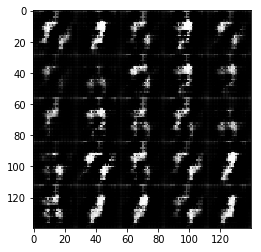

Epoch 1/2... Discriminator Loss: 0.3388... Generator Loss: 2.7118
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.2213
Epoch 1/2... Discriminator Loss: 0.3410... Generator Loss: 2.5758
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 4.4914
Epoch 1/2... Discriminator Loss: 0.1253... Generator Loss: 4.1283
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 1.0198
Epoch 1/2... Discriminator Loss: 0.7587... Generator Loss: 1.2455
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.9921
Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 3.8265
Epoch 1/2... Discriminator Loss: 0.2404... Generator Loss: 5.0821


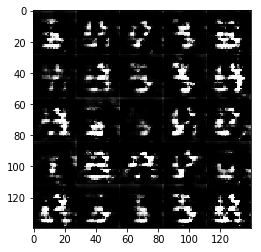

Epoch 1/2... Discriminator Loss: 2.6176... Generator Loss: 0.2646
Epoch 1/2... Discriminator Loss: 0.6540... Generator Loss: 2.2816
Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 2.7831
Epoch 1/2... Discriminator Loss: 0.6322... Generator Loss: 1.2376
Epoch 1/2... Discriminator Loss: 2.0367... Generator Loss: 0.4184
Epoch 1/2... Discriminator Loss: 0.7776... Generator Loss: 2.0758
Epoch 1/2... Discriminator Loss: 1.5133... Generator Loss: 0.3794
Epoch 1/2... Discriminator Loss: 0.5050... Generator Loss: 1.8891
Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 1.5039
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 5.1313


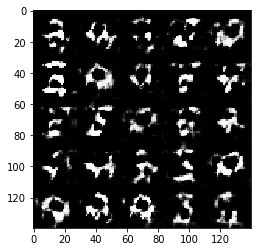

Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.4416
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 4.4561
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 3.1904
Epoch 1/2... Discriminator Loss: 0.7679... Generator Loss: 2.0908
Epoch 1/2... Discriminator Loss: 1.2942... Generator Loss: 1.5847
Epoch 1/2... Discriminator Loss: 0.6085... Generator Loss: 1.4684
Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 2.5494
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 3.7739


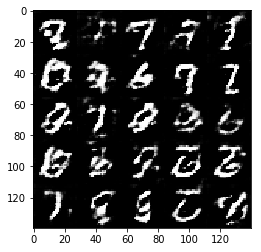

Epoch 1/2... Discriminator Loss: 0.6628... Generator Loss: 1.4442
Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 0.8488
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 1.9531
Epoch 1/2... Discriminator Loss: 0.6845... Generator Loss: 1.8895
Epoch 1/2... Discriminator Loss: 1.6123... Generator Loss: 0.3791
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 1.4605
Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 0.9591
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 0.5974... Generator Loss: 1.5036


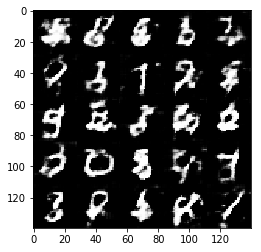

Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 1.5999... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.9098
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 0.8572... Generator Loss: 2.5591
Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 0.5380
Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.8240
Epoch 1/2... Discriminator Loss: 0.6952... Generator Loss: 1.2665


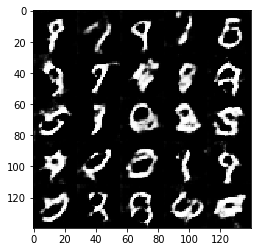

Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 1.2152
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 2.8910
Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 0.8425
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 1.4541
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.0247
Epoch 1/2... Discriminator Loss: 0.7303... Generator Loss: 1.4984
Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 1.9798
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 0.9550
Epoch 1/2... Discriminator Loss: 1.7312... Generator Loss: 0.3007


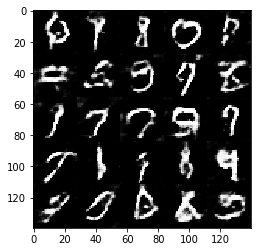

Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.6086
Epoch 1/2... Discriminator Loss: 0.7616... Generator Loss: 1.6991
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 2.4664
Epoch 1/2... Discriminator Loss: 1.9759... Generator Loss: 0.2517
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.5655
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 1.4546
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 0.6399
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 0.8608
Epoch 1/2... Discriminator Loss: 1.0799... Generator Loss: 2.4195
Epoch 1/2... Discriminator Loss: 1.7368... Generator Loss: 0.3271


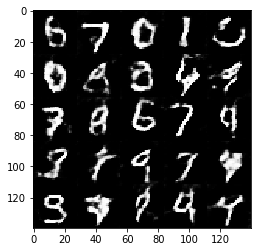

Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.4616
Epoch 1/2... Discriminator Loss: 0.8438... Generator Loss: 1.0338
Epoch 1/2... Discriminator Loss: 2.2782... Generator Loss: 0.1973
Epoch 1/2... Discriminator Loss: 1.9417... Generator Loss: 0.2418
Epoch 1/2... Discriminator Loss: 1.8157... Generator Loss: 0.3047
Epoch 1/2... Discriminator Loss: 0.8103... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 0.7736... Generator Loss: 1.3227
Epoch 1/2... Discriminator Loss: 0.6979... Generator Loss: 1.2385
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.4712


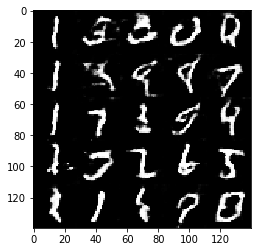

Epoch 1/2... Discriminator Loss: 0.9812... Generator Loss: 1.9050
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 1.8013
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.9100
Epoch 2/2... Discriminator Loss: 1.0652... Generator Loss: 0.6441
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.0834
Epoch 2/2... Discriminator Loss: 0.7862... Generator Loss: 1.0010
Epoch 2/2... Discriminator Loss: 1.4032... Generator Loss: 0.4110
Epoch 2/2... Discriminator Loss: 0.8724... Generator Loss: 2.6942
Epoch 2/2... Discriminator Loss: 0.6162... Generator Loss: 2.0108
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 0.8636


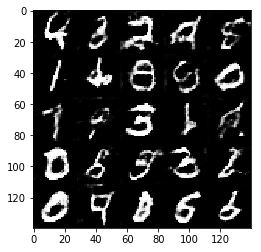

Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 3.5190
Epoch 2/2... Discriminator Loss: 2.2196... Generator Loss: 0.2019
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.5222
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 2.2131
Epoch 2/2... Discriminator Loss: 1.4103... Generator Loss: 0.4452
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 2.3214
Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 1.6090


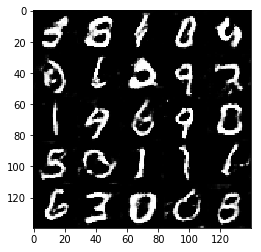

Epoch 2/2... Discriminator Loss: 1.7200... Generator Loss: 0.2946
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 1.7829
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 0.5575... Generator Loss: 1.6318
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.4185
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 0.8951
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.4764
Epoch 2/2... Discriminator Loss: 0.7298... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.6392


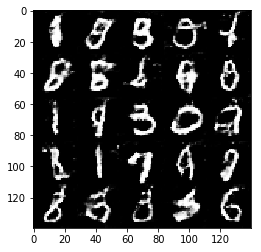

Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 0.9092... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 2.0849
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 0.8691... Generator Loss: 2.2239
Epoch 2/2... Discriminator Loss: 1.7058... Generator Loss: 0.3287
Epoch 2/2... Discriminator Loss: 1.8700... Generator Loss: 0.2444
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 0.8065
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 1.2123


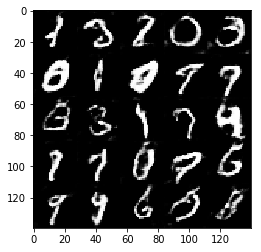

Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5431
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.8859
Epoch 2/2... Discriminator Loss: 1.1701... Generator Loss: 2.1971
Epoch 2/2... Discriminator Loss: 1.1457... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 1.0249
Epoch 2/2... Discriminator Loss: 0.7486... Generator Loss: 1.5456
Epoch 2/2... Discriminator Loss: 0.7541... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 0.6102... Generator Loss: 1.2803
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 1.5470
Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 0.9008


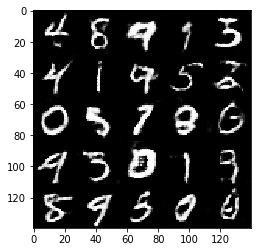

Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.1112
Epoch 2/2... Discriminator Loss: 0.5409... Generator Loss: 1.5703
Epoch 2/2... Discriminator Loss: 2.2089... Generator Loss: 0.1628
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 1.8567
Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 0.7588
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.3793
Epoch 2/2... Discriminator Loss: 1.8372... Generator Loss: 0.3659
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 0.9653
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 0.7903


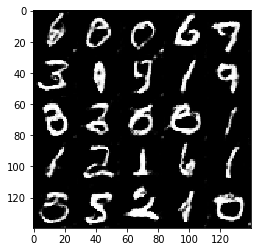

Epoch 2/2... Discriminator Loss: 0.4343... Generator Loss: 1.7799
Epoch 2/2... Discriminator Loss: 1.0440... Generator Loss: 2.4224
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.2288
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 0.7876... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.6469
Epoch 2/2... Discriminator Loss: 2.6380... Generator Loss: 0.2137
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 1.0079
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 2.6063


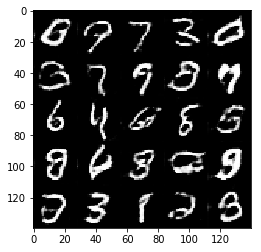

Epoch 2/2... Discriminator Loss: 0.9695... Generator Loss: 2.7765
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.5781... Generator Loss: 0.3415
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.5881
Epoch 2/2... Discriminator Loss: 0.6296... Generator Loss: 1.7061
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.7595
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.1464
Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.4515... Generator Loss: 0.4758


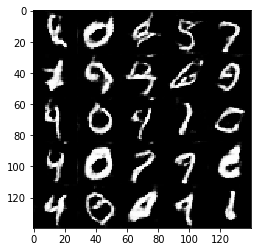

Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.7744
Epoch 2/2... Discriminator Loss: 0.6651... Generator Loss: 1.3651
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 2.5375
Epoch 2/2... Discriminator Loss: 1.4910... Generator Loss: 0.3929
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 2.0986
Epoch 2/2... Discriminator Loss: 0.9838... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.3514
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.5720
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 2.3001... Generator Loss: 0.1827


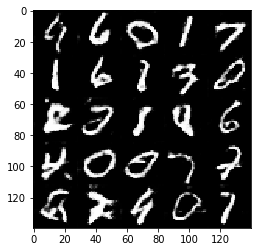

Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 0.7207
Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 1.1872
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 2.2340
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 1.4191... Generator Loss: 0.4136
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.7138... Generator Loss: 0.3485


In [ ]:
z_dim = 100 # The dimension "size" of Z
beta1 = 0.5 # The exponential decay rate for the 1st moment in the optimizer
batch_size = 64 # The size of each amount of samples per processing
learning_rate = 0.002


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 7.9797
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 0.0412... Generator Loss: 6.9461
Epoch 1/1... Discriminator Loss: 0.3235... Generator Loss: 7.9566
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 3.2059
Epoch 1/1... Discriminator Loss: 4.4299... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 5.4818
Epoch 1/1... Discriminator Loss: 0.3695... Generator Loss: 3.1989
Epoch 1/1... Discriminator Loss: 3.0054... Generator Loss: 8.5501
Epoch 1/1... Discriminator Loss: 0.2689... Generator Loss: 2.3064


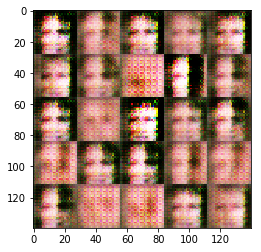

Epoch 1/1... Discriminator Loss: 0.2751... Generator Loss: 3.3407
Epoch 1/1... Discriminator Loss: 1.8533... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 1.3529
Epoch 1/1... Discriminator Loss: 3.7336... Generator Loss: 0.0530
Epoch 1/1... Discriminator Loss: 0.4477... Generator Loss: 1.8312
Epoch 1/1... Discriminator Loss: 0.2560... Generator Loss: 2.0713
Epoch 1/1... Discriminator Loss: 0.4029... Generator Loss: 2.0235
Epoch 1/1... Discriminator Loss: 0.3443... Generator Loss: 2.1803
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 2.1314
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 1.0061


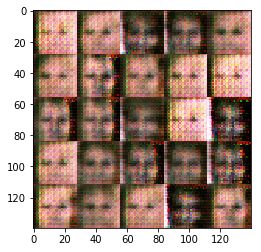

Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 0.9226
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 0.2477
Epoch 1/1... Discriminator Loss: 0.4587... Generator Loss: 1.6478
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 0.7651... Generator Loss: 1.0668
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 1.2789


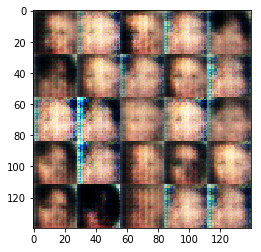

Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 1.5243
Epoch 1/1... Discriminator Loss: 1.8680... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.0531
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.7573


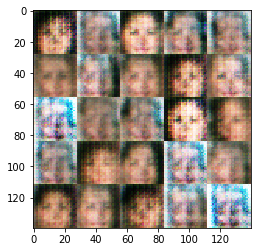

Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 2.2817... Generator Loss: 3.8795


In [ ]:
z_dim = z_dim
beta1 = beta1
batch_size = batch_size
learning_rate = learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.